In [1]:
import atlite
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, LineString, Point

import yaml
from yaml.loader import SafeLoader
from urllib.request import urlretrieve

Die 5 Insel sind folgendes
- Batanes
- Bohol
- Catanduanes
- Marinduque
- Tawi-Tawi

In [5]:
turbine_df = pd.read_csv('turbine.csv').rename(columns={'Unnamed: 0':'turbine'}).set_index('turbine')

turbine_typ = ['WES250','Vestas_V25_200kW','VesV20','En18','JI20kW']
island = ["Batanes","Bohol","Catanduanes","Marinduque","Tawi-Tawi"]
years = ["1980","1990","2000","2010","2020"]

nopower_df = pd.DataFrame(columns=island,index=pd.MultiIndex.from_product([years, turbine_typ]))

for (y,t) in nopower_df.index:
    turbine = turbine_df.loc[t]
    neg_turbine = turbine.copy(deep=True)
    
    for i in neg_turbine.index:
        if neg_turbine.loc[i] == 0:
            neg_turbine.loc[i] = 1
        elif isinstance(neg_turbine.loc[i], float):
            neg_turbine.loc[i] = 0
    
    for r in nopower_df.columns:
        hub_height = round(float(turbine['HUB_HEIGHT']))
        while True:
            try:
                wind_df = pd.read_csv(f"wind_histogram/wind_hist_{hub_height}_n.csv").rename(columns={'Unnamed: 0':'region'}).set_index(['region','year'])
            except FileNotFoundError:
                hub_height = turbine['HUB_HEIGHT']
                continue
            break
        wind = wind_df.loc[r,int(y)]
        nopower_df.loc[(y,t),r] = sum(neg_turbine.loc[str(n)]*wind.loc[str(n)] for n in range(len(wind)))


In [7]:
nopower_df.to_csv('results/flautenanalyse_h_a.csv')
nopower_df

Batanes Bohol Catanduanes Marinduque Tawi-Tawi
1980 WES250               375  3783        2016       3456      3900
     Vestas_V25_200kW     867  5340        3675       4987      6182
     VesV20              1570  6997        5439       6423      7755
     En18                 870  5353        3692       4993      6192
     JI20kW              1840  7714        5993       6884      8018
1990 WES250               612  3168        2106       3481      2807
     Vestas_V25_200kW    1274  4537        3613       5146      5314
     VesV20              2076  6792        5303       6659      7164
     En18                1276  4556        3627       5166      5327
     JI20kW              2370  7657        5868       7207      7565
2000 WES250               470  4150        2422       3443      3814
     Vestas_V25_200kW     956  5974        3964       5088      6313
     VesV20              1867  7632        5552       6569      7753
     En18                 959  5997        3973       5101      6328
     JI20kW              2223  8124        6036       7037      7958
2010 WES250               666  4310        2294       4238      4181
     Vestas_V25_200kW    1291  5862        4306       5816      6625
     VesV20              2238  7751        6244       6930      7955
     En18                1300  5877        4318       5835      6632
     JI20kW              2576  8311        6698       7401      8201
2020 WES250               591  4213        2185       3977      3741
     Vestas_V25_200kW    1265  5812        4051       5418      5914
     VesV20              2112  7484        5868       6678      7529
     En18                1266  5820        4066       5434      5920
     JI20kW              2460  8022        6421       7069      7777

# Create Graph

In [2]:
nopower_df = pd.read_csv("results/flautenanalyse_h_a.csv").rename(columns={'Unnamed: 0':'year','Unnamed: 1':'turbine'})
nopower_df

,year,turbine,Batanes,Bohol,Catanduanes,Marinduque,Tawi-Tawi
0,1980,WES250,375,3783,2016,3456,3900
1,1980,Vestas_V25_200kW,867,5340,3675,4987,6182
2,1980,VesV20,1570,6997,5439,6423,7755
3,1980,En18,870,5353,3692,4993,6192
4,1980,JI20kW,1840,7714,5993,6884,8018
5,1990,WES250,612,3168,2106,3481,2807
6,1990,Vestas_V25_200kW,1274,4537,3613,5146,5314
7,1990,VesV20,2076,6792,5303,6659,7164
8,1990,En18,1276,4556,3627,5166,5327
9,1990,JI20kW,2370,7657,5868,7207,7565


In [3]:
nopower_df["plot"] = 0
for i in nopower_df.index:
    if nopower_df.loc[i,"turbine"] == "WES250":
        nopower_df.loc[i,"plot"] = 1
    if nopower_df.loc[i,"turbine"] == "Vestas_V25_200kW":
        nopower_df.loc[i,"plot"] = 2
    if nopower_df.loc[i,"turbine"] == "VesV20":
        nopower_df.loc[i,"plot"] = 3
    if nopower_df.loc[i,"turbine"] == "En18":
        nopower_df.loc[i,"plot"] = 4
    if nopower_df.loc[i,"turbine"] == "JI20kW":
        nopower_df.loc[i,"plot"] = 5

C:\Users\kunde\AppData\Local\Temp\ipykernel_5980\2497434794.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['','WES250','Vestas_V25_200kW','VesV20','En18','JI20kW',''])


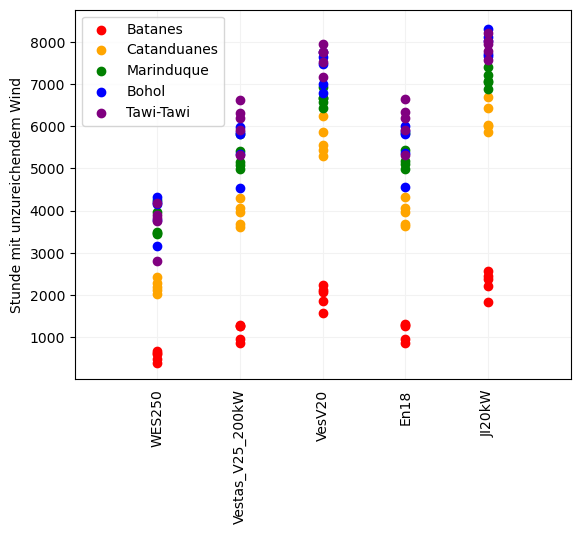

In [7]:
# The target ist to create an array where the color is based on the region while the axis is based on
fig, ax = plt.subplots()#figsize=(7,6)

plt.scatter(nopower_df["plot"], nopower_df['Batanes'], c='red', label='Batanes')
plt.scatter(nopower_df["plot"], nopower_df['Catanduanes'], c='orange', label='Catanduanes')
plt.scatter(nopower_df["plot"], nopower_df['Marinduque'], c='green', label='Marinduque')
plt.scatter(nopower_df["plot"], nopower_df['Bohol'], c='blue', label='Bohol')
plt.scatter(nopower_df["plot"], nopower_df['Tawi-Tawi'], c='purple', label='Tawi-Tawi')

#plt.yscale('log')
ax.set(xticklabels=['','WES250','Vestas_V25_200kW','VesV20','En18','JI20kW',''])
#ax.set(yticklabels=['','0 MWh','10 MWh','100 MWh','1000 MWh'])

plt.xticks(rotation=90)
ax.tick_params(bottom=False)
plt.ylim([1, 8760])
plt.xlim([0, 6])

plt.grid(axis='x',color='0.95', which='major')
plt.grid(axis='y',color='0.95', which='both')
ax.set_axisbelow(True)

plt.legend()
plt.ylabel('Stunde mit unzureichendem Wind')

plt.savefig('flauten.png')

# Other thing

In [10]:
def extrapolate_wind_speed(hub_height,year):
    
    # v = v ref ln(z/z 0 )/ln(z ref /z 0 )
    cutout = atlite.Cutout(f"PHL_atlite_{year}.nc")
    wind_100 = cutout.data.wnd100m
    roughness = cutout.data.roughness
    wind_array = wind_100 * np.log(hub_height/roughness)/np.log(100/roughness)
    
    return wind_array

def region_wind(wind_array,region):
    cell_data=[]
    for x in np.arange(116.75,126.57,0.25):
        x = round(x,2)
        for y in np.arange(4.5,21.25,0.25):
            buffer = Point(x, y).buffer(0.25, cap_style = 3)
            if region.simplify(0.1).overlaps(buffer):
                x_cell = int((x - 116.8)*4)
                y_cell = int((y - 4.5)*4)
                cell_data= cell_data + [[y_cell,x_cell]]

    return sum(wind_array[:,y,x].to_pandas() for y,x in cell_data)/len(cell_data)

In [14]:
regions = gpd.read_file("gadm_410-levels-ADM_1-PHL.gpkg")

region=10
wind_height=30

wind_array = extrapolate_wind_speed(wind_height,"2020")
wind_series = region_wind(wind_array,regions.geometry[region])

In [16]:
wind_series

time
2020-01-01 00:00:00    14.420557
2020-01-01 01:00:00    14.502035
2020-01-01 02:00:00    14.366391
2020-01-01 03:00:00    14.172201
2020-01-01 04:00:00    13.824707
                         ...    
2020-12-31 19:00:00    11.922174
2020-12-31 20:00:00    11.813945
2020-12-31 21:00:00    11.869819
2020-12-31 22:00:00    11.010721
2020-12-31 23:00:00    11.501553
Length: 8784, dtype: float32

In [17]:
wind_series.to_csv('wind_series_test.csv')

<AxesSubplot:xlabel='time'>

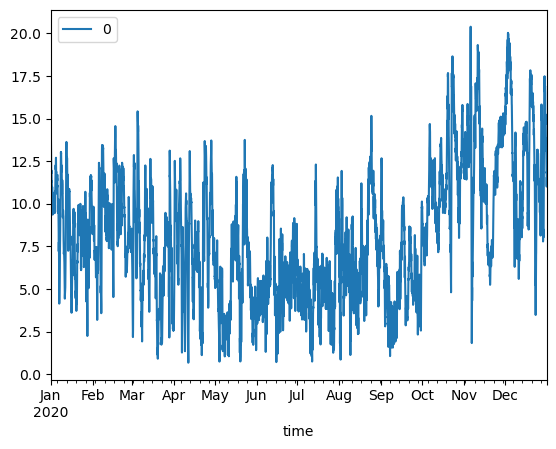

In [35]:
wind_series = pd.read_csv('wind_series_test.csv',index_col=0, parse_dates=True)
wind_series.plot()

In [38]:
for i in wind_series.index:
    if wind_series.loc[i,'0'] < 12:
        wind_series.loc[i,'0'] = 0

wind_series.groupby(wind_series['0'].diff().ne(0).cumsum()).cumcount()

time
2020-01-01 00:00:00    0
2020-01-01 01:00:00    0
2020-01-01 02:00:00    0
2020-01-01 03:00:00    0
2020-01-01 04:00:00    0
                      ..
2020-12-31 19:00:00    0
2020-12-31 20:00:00    1
2020-12-31 21:00:00    2
2020-12-31 22:00:00    3
2020-12-31 23:00:00    4
Length: 8784, dtype: int64

In [39]:
wind_series

,0
time,
2020-01-01 00:00:00,14.420557
2020-01-01 01:00:00,14.502035
2020-01-01 02:00:00,14.366391
2020-01-01 03:00:00,14.172201
2020-01-01 04:00:00,13.824707
...,...
2020-12-31 19:00:00,0.000000
2020-12-31 20:00:00,0.000000
2020-12-31 21:00:00,0.000000
